In [6]:
import random
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from tsp import AnnealingSolver
from mst_prim import prim_mst, createRoutes
from leach import LeachSolver
from nemo import evaluate_nemo
import util
from util import lighten_color
import seaborn as sns
from util import centroid_label, ch_label, coordinator_label, worker_label, ccolor, cmarker
from topology import get_lognorm_hist
import topology
from scipy.spatial import cKDTree

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Topology Setup

In [7]:
seed = 4
np.random.seed(seed)

avg = 50
c_capacity = 50

H, bins = get_lognorm_hist()
coords_df = topology.coords_ripe_atlas(path="datasets/RIPEAtlas/19062023/time-0_2d.csv")
coords_df['latency'] = list(zip(coords_df.x, coords_df.y))
coords_df['latency'] = coords_df['latency'].apply(lambda x: np.linalg.norm(x - coords_df.loc[0, ["x", "y"]].to_numpy()))

coord_dict = {"atlas": coords_df}
device_number = coords_df.shape[0]
max_resources = device_number * avg - c_capacity

df_dict_topologies = topology.create_topologies_from_dict(coord_dict, H, max_resources, c_capacity,
                                                          weights=(1, avg * 2), dist="lognorm", with_clustering=True,
                                                          kmin=2, kmax=30, kseed=10)

Creating df for atlas
Optimal k is 8
Done


In [8]:
df_rtt = pd.read_csv("datasets/RIPEAtlas/19062023/rtt_time-0.csv", sep=",", skiprows=1, header=None)
df_rtt.columns = range(0, len(df_rtt.columns))
for i in list(df_rtt.index):
    df_rtt.at[i, i] = 0
df_rtt

,0,1,2,3,4,5,6,7,8,9,...,409,410,411,412,413,414,415,416,417,418
0,0.0,22.0,52.0,72.0,115.0,122.0,84.0,68.0,116.0,27.0,...,239.0,260.0,103.0,169.0,172.0,274.0,196.0,256.0,289.0,273.0
1,22.0,0.0,26.0,50.0,269.0,222.0,205.0,180.0,181.0,254.0,...,314.0,173.0,182.0,160.0,160.0,233.0,197.0,247.0,205.0,184.0
2,52.0,26.0,0.0,78.0,122.0,138.0,98.0,76.0,133.0,29.0,...,253.0,174.0,107.0,196.0,184.0,199.0,209.0,248.0,192.0,197.0
3,72.0,50.0,78.0,0.0,205.0,161.0,49.0,204.0,223.0,188.0,...,277.0,199.0,227.0,199.0,197.0,211.0,238.0,307.0,243.0,220.0
4,115.0,269.0,122.0,205.0,0.0,200.0,102.0,138.0,71.0,92.0,...,318.0,296.0,287.0,245.0,248.0,285.0,292.0,382.0,330.0,279.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,274.0,233.0,199.0,211.0,285.0,163.0,222.0,192.0,298.0,164.0,...,80.0,32.0,151.0,35.0,31.0,0.0,63.0,112.0,68.0,51.0
415,196.0,197.0,209.0,238.0,292.0,230.0,216.0,200.0,305.0,274.0,...,99.0,43.0,158.0,41.0,37.0,63.0,0.0,57.0,9.0,6.0
416,256.0,247.0,248.0,307.0,382.0,287.0,259.0,260.0,351.0,257.0,...,151.0,99.0,221.0,89.0,89.0,112.0,57.0,0.0,51.0,93.0
417,289.0,205.0,192.0,243.0,330.0,228.0,228.0,210.0,291.0,198.0,...,107.0,49.0,183.0,45.0,43.0,68.0,9.0,51.0,0.0,16.0


In [9]:
df = df_rtt
for thresh in range(df.shape[0], 1, -1):
    df = df.loc[df.eq(0).sum(axis=1) < thresh, df.eq(0).sum(axis=1) < thresh]

In [10]:
df

,0,1,2,3,4,5,6,7,8,9,...,409,410,411,412,413,414,415,416,417,418
0,0.0,22.0,52.0,72.0,115.0,122.0,84.0,68.0,116.0,27.0,...,239.0,260.0,103.0,169.0,172.0,274.0,196.0,256.0,289.0,273.0
1,22.0,0.0,26.0,50.0,269.0,222.0,205.0,180.0,181.0,254.0,...,314.0,173.0,182.0,160.0,160.0,233.0,197.0,247.0,205.0,184.0
2,52.0,26.0,0.0,78.0,122.0,138.0,98.0,76.0,133.0,29.0,...,253.0,174.0,107.0,196.0,184.0,199.0,209.0,248.0,192.0,197.0
3,72.0,50.0,78.0,0.0,205.0,161.0,49.0,204.0,223.0,188.0,...,277.0,199.0,227.0,199.0,197.0,211.0,238.0,307.0,243.0,220.0
4,115.0,269.0,122.0,205.0,0.0,200.0,102.0,138.0,71.0,92.0,...,318.0,296.0,287.0,245.0,248.0,285.0,292.0,382.0,330.0,279.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,274.0,233.0,199.0,211.0,285.0,163.0,222.0,192.0,298.0,164.0,...,80.0,32.0,151.0,35.0,31.0,0.0,63.0,112.0,68.0,51.0
415,196.0,197.0,209.0,238.0,292.0,230.0,216.0,200.0,305.0,274.0,...,99.0,43.0,158.0,41.0,37.0,63.0,0.0,57.0,9.0,6.0
416,256.0,247.0,248.0,307.0,382.0,287.0,259.0,260.0,351.0,257.0,...,151.0,99.0,221.0,89.0,89.0,112.0,57.0,0.0,51.0,93.0
417,289.0,205.0,192.0,243.0,330.0,228.0,228.0,210.0,291.0,198.0,...,107.0,49.0,183.0,45.0,43.0,68.0,9.0,51.0,0.0,16.0


In [11]:
t_label = "atlas"
prim_df, c_coords, base_col, slot_columns, centroids, opt_k, sil = df_dict_topologies[t_label]
prim_df["weight_1"] = 1
prim_df["weight_2"] = 2
coords = prim_df[["x", "y"]].to_numpy()

eval_matrix = {}
prim_df

,x,y,latency,type,base,weight,capacity_100,capacity_90,capacity_80,capacity_70,...,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1,cluster,weight_1,weight_2
0,202.799027,-47.855208,0.000000,coordinator,175561,0,50,50,50,50,...,50,50,50,50,50,50,50,-1,1,2
1,75.871395,-234.463748,225.684228,worker,175561,12,50,51,47,58,...,64,38,63,25,57,40,113,3,1,2
2,163.403715,-74.629814,47.632658,worker,175561,1,50,50,47,48,...,42,66,44,31,29,10,4,0,1,2
3,181.481740,7.832968,59.628850,worker,175561,2,50,48,49,47,...,44,33,36,34,74,23,8,0,1,2
4,231.431512,45.783553,97.918521,worker,175561,3,50,51,46,46,...,47,33,79,46,17,15,61,7,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,2.079037,-11.842929,203.924983,worker,175561,2,50,53,54,46,...,54,51,30,50,25,20,4,1,1,2
415,-8.101378,-47.514485,210.900681,worker,175561,1,50,49,47,50,...,42,62,31,52,48,60,162,1,1,2
416,-43.537057,-101.535160,252.117044,worker,175561,1,50,52,56,44,...,37,59,60,74,27,93,12,1,1,2
417,-50.357446,-43.098096,253.201165,worker,175561,2,50,48,56,50,...,38,62,30,77,42,58,4,1,1,2


In [12]:
print("Required:", prim_df["weight"].sum(), "Available:", prim_df["capacity_100"].sum())
colors, light_colors, palette = util.get_color_list(opt_k)
palette

Required: 2939 Available: 20950


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)]

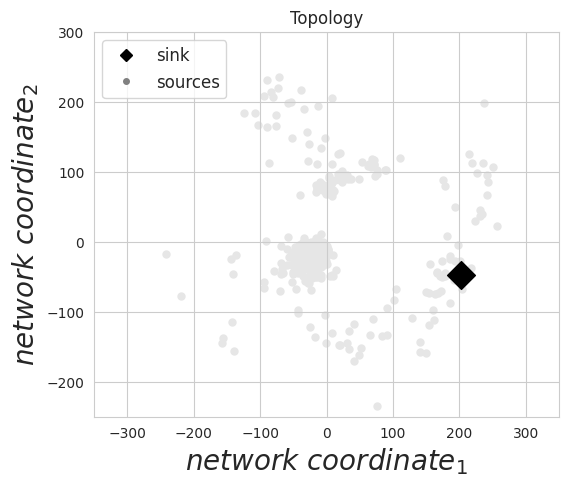

In [36]:
X_dim_def = [-350, 350]
Y_dim_def = [-250, 300]

fig, (ax1) = plt.subplots(1, 1, figsize=(6, 5))
ax1 = util.plot_topology(ax1, prim_df)

ax1.set_xlim(X_dim_def)
ax1.set_ylim(Y_dim_def)

X_dim = ax1.get_xlim()
Y_dim = ax1.get_ylim()

plt.show()

### NCS Clustering with RTTs

In [37]:
# Build the k-d tree for the centroids
cluster_heads = []
kdtree = cKDTree(np.vstack(coords))
for i in range(0, len(centroids)):
    idx = kdtree.query(centroids[i], k=1)[1]
    cluster_heads.append(idx)
cluster_heads

[47, 129, 267, 363, 73, 62, 127, 29]

In [38]:
rtt_labels = []
for i in range(0, prim_df.shape[0]):
    parent_idx = df_rtt.loc[i, cluster_heads].idxmin()
    ch_label = cluster_heads.index(parent_idx)
    rtt_labels.append(ch_label)

## Plotting

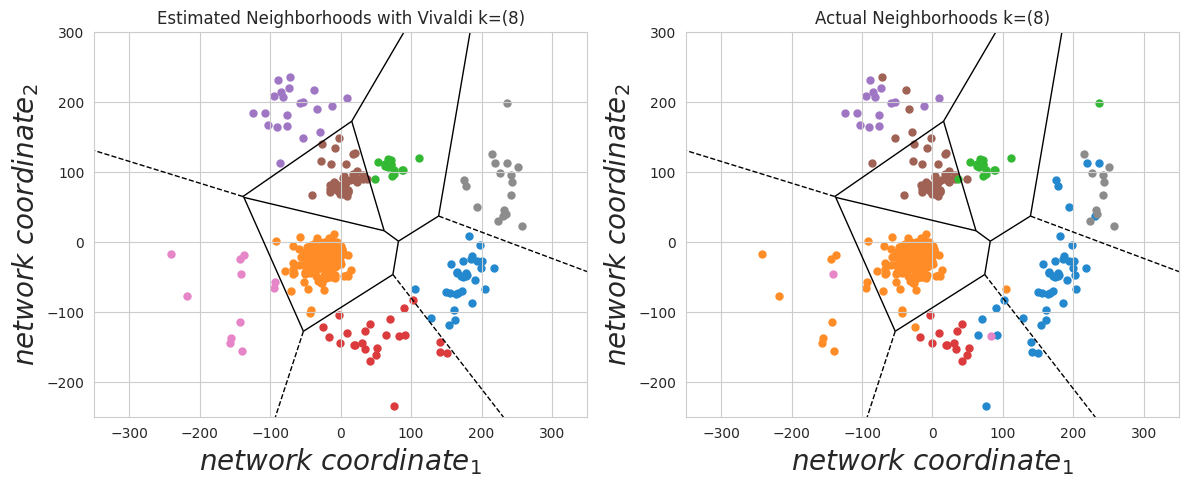

In [50]:
lval = 0.9

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1 = util.plot_topology(ax1, prim_df, colors=colors, title='Topology (k=' + str(opt_k) + ")", lval=lval, plot_voronoi=True, centroids=centroids, show_legend=False, show_coordinator=False)

prim_df_rtt = prim_df.copy()
prim_df_rtt["cluster"] = rtt_labels
ax2 = util.plot_topology(ax2, prim_df_rtt, colors=colors, title='Topology (k=' + str(opt_k) + ")", lval=lval, plot_voronoi=True, centroids=centroids, show_legend=False, show_coordinator=False)

ax1.set_title(f"Estimated Neighborhoods with Vivaldi k=({opt_k})")
ax1.set_xlim(X_dim_def)
ax1.set_ylim(Y_dim_def)

ax2.set_title(f"Actual Neighborhoods k=({opt_k})")
ax2.set_xlim(X_dim_def)
ax2.set_ylim(Y_dim_def)

# plt.savefig("plots/atlas/atlas_ncs_colored.svg", bbox_inches="tight")

plt.show()

### Evaluate the cluster

In [20]:
# Example usage
true_labels = rtt_labels[1:]
predicted_labels = prim_df.loc[1:, "cluster"]

cm, purity_score = util.calculate_purity(true_labels, predicted_labels)
print(f"Purity: {purity_score}")

Purity: 0.9090909090909091


In [21]:
cm

array([[ 29,   0,   0,   9,   0,   0,   0,   6],
       [  1, 247,   0,   2,   0,   0,  10,   0],
       [  0,   0,  16,   0,   0,   1,   0,   1],
       [  0,   0,   0,  13,   0,   0,   0,   0],
       [  0,   0,   0,   0,  15,   0,   0,   0],
       [  0,   0,   1,   0,   6,  49,   0,   0],
       [  0,   0,   0,   1,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,  10]])

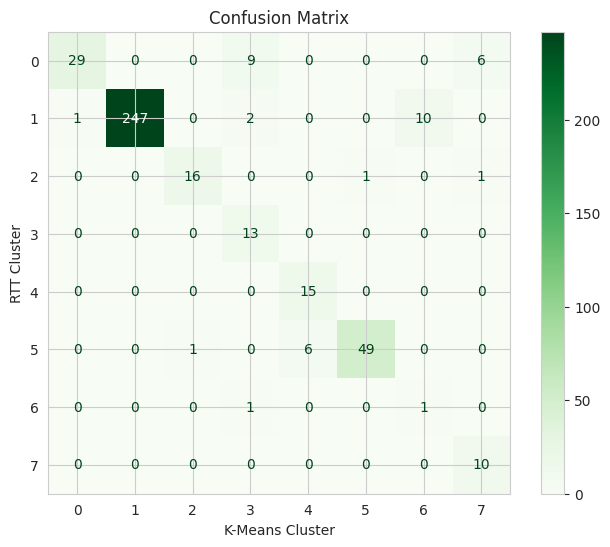

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create a subplot with a specific axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create a ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
disp.plot(cmap='Greens', values_format='g', ax=ax)

ax.set_title("Confusion Matrix")
ax.set_ylabel("RTT Cluster")
ax.set_xlabel("K-Means Cluster")

plt.show()

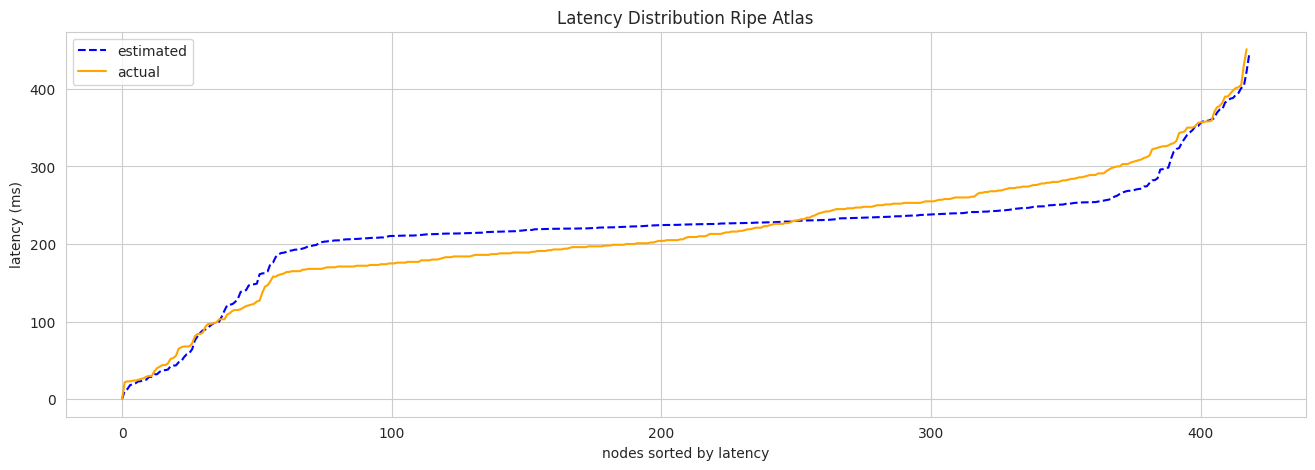

In [47]:
fig, (ax1) = plt.subplots(1, 1, figsize=(16, 5), sharey=False)

sv_direct_trx = coord_dict["atlas"]["latency"].sort_values()
sv_direct_trx.plot(ax=ax1, use_index=False, label="estimated", color="blue", linestyle="--")

sv_rtt_direct_trx = df_rtt.loc[0].sort_values()[:-1]
sv_rtt_direct_trx.plot(ax=ax1, use_index=False, label="actual", color="orange")

ax1.set_title('Latency Distribution Ripe Atlas')
ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('latency (ms)')
ax1.legend(loc="upper left", prop={'size': 10}, ncol=1)

plt.show()